In [1]:
import os
os.chdir('..')
from src.feature_engineering import freture_extract_All
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Show more columns
pd.set_option('display.max_columns', None) 

# Show more rows
pd.set_option('display.max_rows', 100) 

In [2]:
df = freture_extract_All()
df

,member_id,churn,outreach,months_in_app,title_Cardio workouts,title_Cardiometabolic health,title_Cholesterol friendly foods,title_Diabetes management,title_Exercise routines,title_HbA1c targets,title_Healthy eating guide,title_High-fiber meals,title_Hypertension basics,title_Lowering blood pressure,title_Meditation guide,title_Mediterranean diet,title_Restorative sleep tips,title_Sleep hygiene,title_Strength training basics,title_Stress reduction,title_Weight management,total_visits,app_usage,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3,code_count,priority_condition_count
0,1,0,0,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,2.0,9.0,4.0
1,2,0,0,2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,9.0,10.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,9.0,7.0
2,3,0,0,8,3.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,1.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,52.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,1.0
3,4,1,0,13,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,15.0,10.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,5.0,3.0
4,5,0,1,14,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,11.0,10.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0,8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,18.0,8.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,9.0,4.0
9996,9997,0,0,15,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,3.0
9997,9998,0,0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,2.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,2.0,14.0,2.0
9998,9999,0,0,16,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,36.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,6.0,3.0


## Strategy 1 - one model to predict churn

In [3]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [4]:
X = df.drop(columns=['churn', 'member_id'])
y = df['churn']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3333, random_state=42, stratify=y 
)

Classification Report:
              precision    recall  f1-score   support

    no_churn       0.86      0.69      0.76      2659
       churn       0.30      0.54      0.39       674

    accuracy                           0.66      3333
   macro avg       0.58      0.61      0.58      3333
weighted avg       0.74      0.66      0.69      3333


AUC Score: 0.6460


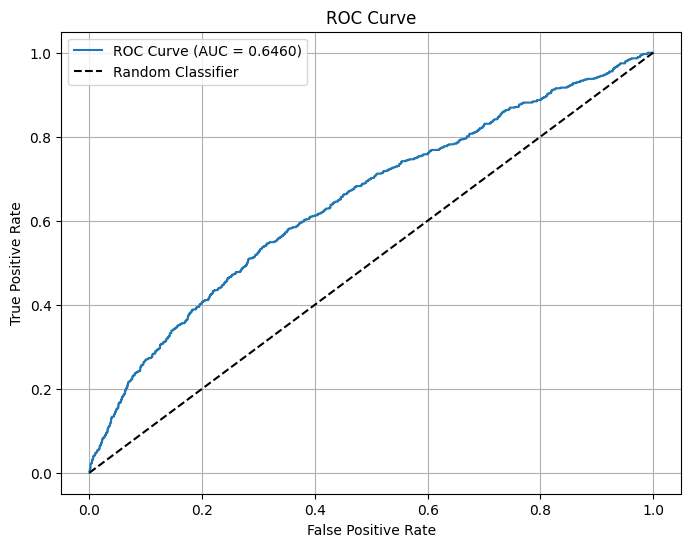

In [6]:
import xgboost as xgb
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
model = xgb.XGBClassifier(
    n_estimators=70,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=scale_weight
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Classification Report
print("Classification Report:")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=['no_churn', 'churn'],
    digits=2
))

# AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc:.4f}")

# Optional: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  # Handles imbalance
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_rf, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

RANDOM FOREST RESULTS
              precision    recall  f1-score   support

    no_churn       0.83      0.84      0.84      2659
       churn       0.35      0.34      0.35       674

    accuracy                           0.74      3333
   macro avg       0.59      0.59      0.59      3333
weighted avg       0.74      0.74      0.74      3333


AUC Score: 0.6496


In [8]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

model_lgb.fit(X_train, y_train)

# Predictions
y_pred_lgb = model_lgb.predict(X_test)
y_pred_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

print("=" * 60)
print("LIGHTGBM RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_lgb, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

LIGHTGBM RESULTS
              precision    recall  f1-score   support

    no_churn       0.85      0.74      0.79      2659
       churn       0.32      0.47      0.38       674

    accuracy                           0.69      3333
   macro avg       0.58      0.61      0.58      3333
weighted avg       0.74      0.69      0.71      3333


AUC Score: 0.6453


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model_lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_lr, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.6f}")

LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

    no_churn       0.87      0.63      0.73      2659
       churn       0.30      0.64      0.41       674

    accuracy                           0.63      3333
   macro avg       0.59      0.64      0.57      3333
weighted avg       0.76      0.63      0.67      3333


AUC Score: 0.684206


In [10]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    auto_class_weights='Balanced',
    random_state=42,
    verbose=False
)

model_cat.fit(X_train, y_train)

# Predictions
y_pred_cat = model_cat.predict(X_test)
y_pred_proba_cat = model_cat.predict_proba(X_test)[:, 1]

print("=" * 60)
print("CATBOOST RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_cat, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")

CATBOOST RESULTS
              precision    recall  f1-score   support

    no_churn       0.86      0.69      0.76      2659
       churn       0.31      0.54      0.39       674

    accuracy                           0.66      3333
   macro avg       0.58      0.62      0.58      3333
weighted avg       0.74      0.66      0.69      3333


AUC Score: 0.6543


## Strategy 2 - two models, one on each portions of outreach.

In [28]:
df = freture_extract_All()
df

,member_id,churn,outreach,months_in_app,title_Cardio workouts,title_Cardiometabolic health,title_Cholesterol friendly foods,title_Diabetes management,title_Exercise routines,title_HbA1c targets,title_Healthy eating guide,title_High-fiber meals,title_Hypertension basics,title_Lowering blood pressure,title_Meditation guide,title_Mediterranean diet,title_Restorative sleep tips,title_Sleep hygiene,title_Strength training basics,title_Stress reduction,title_Weight management,total_visits,app_usage,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3,code_count,priority_condition_count
0,1,0,0,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,0.0,2.0,9.0,4.0
1,2,0,0,2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,9.0,10.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,9.0,7.0
2,3,0,0,8,3.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,1.0,2.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,52.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,1.0
3,4,1,0,13,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,15.0,10.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,5.0,3.0
4,5,0,1,14,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,11.0,10.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0,8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,18.0,8.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,9.0,4.0
9996,9997,0,0,15,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0,11.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,3.0
9997,9998,0,0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,12.0,0.0,2.0,0.0,2.0,0.0,4.0,2.0,1.0,1.0,2.0,14.0,2.0
9998,9999,0,0,16,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,36.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,6.0,3.0


In [29]:
df_outreach = df[df['outreach'] == 1]
df_no_outreach = df[df['outreach'] == 0]

In [30]:
X_outreach = df_outreach.drop(columns=['churn', 'member_id', 'outreach'])
y_outreach = df_outreach['churn']
X_no_outreach = df_no_outreach.drop(columns=['churn', 'member_id', 'outreach'])
y_no_outreach = df_no_outreach['churn']

In [31]:
X_train_outreach, X_test_outreach, y_train_outreach, y_test_outreach = train_test_split(
    X_outreach, y_outreach, test_size=0.3333, random_state=42, stratify=y_outreach 
)
X_train_no_outreach, X_test_no_outreach, y_train_no_outreach, y_test_no_outreach = train_test_split(
    X_no_outreach, y_no_outreach, test_size=0.3333, random_state=42, stratify=y_no_outreach
)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for logistic regression
scalar_outreach = StandardScaler()
scalar_no_outreach = StandardScaler()

X_train_outreach_scaled = scalar_outreach.fit_transform(X_train_outreach)
X_test_outreach_scaled = scalar_outreach.transform(X_test_outreach)
X_train_no_outreach_scaled = scalar_no_outreach.fit_transform(X_train_no_outreach)
X_test_no_outreach_scaled = scalar_no_outreach.transform(X_test_no_outreach)

model_lr_outreach = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
model_lr_no_outreach = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
model_lr_outreach.fit(X_train_outreach_scaled, y_train_outreach)
model_lr_no_outreach.fit(X_train_no_outreach_scaled, y_train_no_outreach)

# Predictions
y_pred_lr_outreach = model_lr_outreach.predict(X_test_outreach_scaled)
y_pred_proba_lr_outreach = model_lr_outreach.predict_proba(X_test_outreach_scaled)[:, 1]
y_pred_lr_no_outreach = model_lr_no_outreach.predict(X_test_no_outreach_scaled)
y_pred_proba_lr_no_outreach = model_lr_no_outreach.predict_proba(X_test_no_outreach_scaled)[:, 1]
print("=" * 60)
print("LOGISTIC REGRESSION RESULTS - OUTREACH GROUP")
print("=" * 60)
print(classification_report(y_test_outreach, y_pred_lr_outreach, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test_outreach, y_pred_proba_lr_outreach):.6f}")
print("=" * 60)
print("LOGISTIC REGRESSION RESULTS - NO OUTREACH GROUP")
print("=" * 60)
print(classification_report(y_test_no_outreach, y_pred_lr_no_outreach, target_names=['no_churn', 'churn'], digits=2))
print(f"\nAUC Score: {roc_auc_score(y_test_no_outreach, y_pred_proba_lr_no_outreach):.6f}")


LOGISTIC REGRESSION RESULTS - OUTREACH GROUP
              precision    recall  f1-score   support

    no_churn       0.86      0.66      0.75      1070
       churn       0.29      0.57      0.38       258

    accuracy                           0.64      1328
   macro avg       0.57      0.61      0.56      1328
weighted avg       0.75      0.64      0.68      1328


AUC Score: 0.663660
LOGISTIC REGRESSION RESULTS - NO OUTREACH GROUP
              precision    recall  f1-score   support

    no_churn       0.86      0.62      0.72      1590
       churn       0.30      0.61      0.40       416

    accuracy                           0.62      2006
   macro avg       0.58      0.62      0.56      2006
weighted avg       0.74      0.62      0.66      2006


AUC Score: 0.667129


## rank calling and decide on optimal 'n'

In [41]:
df_priority = df.drop(columns=['member_id', 'outreach', 'churn'])
df_priority_outreach = scalar_outreach.transform(df_priority)
df_priority_no_outreach = scalar_no_outreach.transform(df_priority)

# get the probabilities of staying
stays_prob_outreach = model_lr_outreach.predict_proba(df_priority_outreach)[:, 0]
stays_prob_no_outreach = model_lr_no_outreach.predict_proba(df_priority_no_outreach)[:, 0]

In [43]:
uplift = stays_prob_outreach - stays_prob_no_outreach
df['uplift'] = uplift
df.sort_values(by='uplift', ascending=False)

,member_id,churn,outreach,months_in_app,title_Cardio workouts,title_Cardiometabolic health,title_Cholesterol friendly foods,title_Diabetes management,title_Exercise routines,title_HbA1c targets,title_Healthy eating guide,title_High-fiber meals,title_Hypertension basics,title_Lowering blood pressure,title_Meditation guide,title_Mediterranean diet,title_Restorative sleep tips,title_Sleep hygiene,title_Strength training basics,title_Stress reduction,title_Weight management,total_visits,app_usage,icd_code_A09,icd_code_B34.9,icd_code_E11.9,icd_code_H10.9,icd_code_I10,icd_code_J00,icd_code_K21.9,icd_code_M54.5,icd_code_R51,icd_code_Z71.3,code_count,priority_condition_count,uplift
8319,8320,0,1,16,0.0,4.0,0.0,2.0,1.0,1.0,0.0,1.0,3.0,2.0,1.0,1.0,8.0,0.0,5.0,0.0,1.0,68.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,6.0,4.0,0.399930
4591,4592,0,1,13,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,3.0,1.0,0.0,34.0,10.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,5.0,0.0,0.387430
5744,5745,1,1,1,2.0,0.0,2.0,1.0,1.0,0.0,2.0,3.0,1.0,2.0,0.0,1.0,4.0,0.0,6.0,2.0,0.0,57.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0,1.0,0.368171
8039,8040,0,0,15,0.0,3.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,34.0,11.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,5.0,1.0,0.365222
6490,6491,0,0,10,2.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,4.0,1.0,0.0,66.0,10.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.363602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7692,7693,0,0,0,2.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,0.0,4.0,2.0,1.0,1.0,3.0,4.0,2.0,81.0,12.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,8.0,2.0,-0.342561
9102,9103,0,0,3,0.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,3.0,3.0,4.0,1.0,0.0,2.0,1.0,1.0,5.0,83.0,5.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,12.0,4.0,-0.351823
2031,2032,0,0,4,0.0,1.0,3.0,5.0,1.0,2.0,1.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,3.0,2.0,62.0,7.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,5.0,2.0,-0.394972
4498,4499,0,1,0,1.0,0.0,0.0,2.0,2.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,3.0,60.0,10.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,9.0,3.0,-0.404036


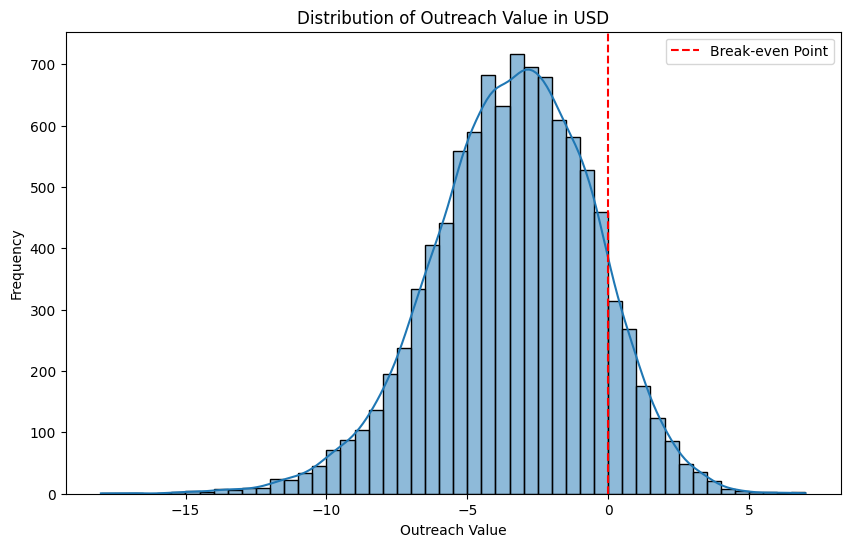

In [54]:
cost_per_call = 5  # Example cost per outreach call
value_per_retention = 30  # Example value per retained customer

df['outreach_value'] = df['uplift'] * value_per_retention - cost_per_call
df.sort_values(by='outreach_value', ascending=False)

# Visualize the distribution of outreach_value
plt.figure(figsize=(10, 6))
sns.histplot(df['outreach_value'], bins=50, kde=True)
plt.title('Distribution of Outreach Value in USD')
plt.xlabel('Outreach Value')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Break-even Point')
plt.legend()
plt.show()

In [55]:
print('optimal n is:' + str(len(df[df['outreach_value'] > 0])))  # Example thresholding at positive value

optimal n is:1087
